# FE 691 Final Project

#### Imports

In [10]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import pandas as pd
from yahooquery import Ticker
import numpy as np
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import confusion_matrix, accuracy_score

## Model Variables

In [11]:
# Symbols we are interested in checking
symbols = ['btc-usd', 'mara', 'gbtc', 'riot', 'hut', 'hive', 'gc=f']

# Date Range of Training
train_start = '2017-01-01'
train_end = '2023-01-01'

# Date Range of Testing
test_start = '2023-01-01'
test_end = '2023-12-01'

# Symbols we want in our pair
stock1 = 'riot'
stock2 = 'mara'

# Selected data-set to use
# Options (close, logclose, ret_cum, logret_cum, ret, log_ret, norm)
option = 'ret_cum'

## Data Collection

#### API Calls

In [12]:
# Get data on symbols
data = Ticker(symbols)

# Extract the training adjclose data
tr = data.history(start = train_start, end = train_end)
tr_close = pd.DataFrame()
for sym in tr.index.get_level_values(0).unique():
    tr_close[sym] = tr['adjclose'][sym]

tr_close.dropna(inplace = True)

# Extract the testing adjclose data
te = data.history(start = test_start, end = test_end)
te_close = pd.DataFrame()
for sym in te.index.get_level_values(0).unique():
    te_close[sym] = te['adjclose'][sym]

te_close.dropna(inplace = True)

# ===================================================

# Get data on benchmarks
bench_syms = [stock1, stock2, 'spy', 'vmnfx']
bench_data = Ticker(bench_syms)

# Extract the testiong benchmark data
te_bench = bench_data.history(start = test_start, end = test_end)
te_bench_close = pd.DataFrame()
for sym in te_bench.index.get_level_values(0).unique():
    te_bench_close[sym] = te_bench['adjclose'][sym]

te_bench_close.dropna(inplace = True)

#### Datasets Generation
Get the log close prices, returns, log returns, etc.

In [13]:
# Normalizes the price data
def normalize(data):
    max = data.max()
    min = data.min()
    norm_data = (data - min) / (max - min)
    return norm_data

In [14]:
def compute_datasets(close):
    # Get log close
    logclose = np.log(close)

    # Get returns
    ret = close.pct_change().dropna()
    logret = np.log(1 + close.pct_change()).dropna()

    # Get cumulative returns
    logret_cum = np.cumsum(logret)
    ret_cum = np.exp(logret_cum) - 1

    # Remove first value of close and logclose for alignment
    close = close.iloc[1:]
    logclose = logclose.iloc[1:]

    # Get normalized prices
    norm = normalize(close)

    # Establish the key value pairs
    dataset_list = [close, logclose, ret_cum, logret_cum, ret, logret, norm]
    keys = ['close', 'logclose', 'ret_cum', 'logret_cum', 'ret', 'logret', 'norm']

    # Put into the dictionary
    dataset_dict = {}
    for i, dataset in enumerate(dataset_list):
        dataset_dict[keys[i]] = dataset

    return dataset_dict

In [15]:
# Get all datasets
tr_datasets = compute_datasets(tr_close)
te_datasets = compute_datasets(te_close)

## Pairs Validity Testing

#### Correlation Analysis

In [16]:
# Get returns and log returns
ret = tr_close.pct_change().dropna()
logret = np.log(1 + tr_close.pct_change()).dropna()
logret.corr()

,btc-usd,mara,gbtc,riot,hut,hive,gc=f
btc-usd,1.000000,0.508984,0.801466,0.547729,0.530780,0.569096,0.128990
mara,0.508984,1.000000,0.610799,0.748137,0.575622,0.597267,0.079613
gbtc,0.801466,0.610799,1.000000,0.639174,0.589083,0.667396,0.147959
riot,0.547729,0.748137,0.639174,1.000000,0.564321,0.609590,0.115052
hut,0.530780,0.575622,0.589083,0.564321,1.000000,0.578356,0.080842
hive,0.569096,0.597267,0.667396,0.609590,0.578356,1.000000,0.124563
gc=f,0.128990,0.079613,0.147959,0.115052,0.080842,0.124563,1.000000


#### Cointegration Analysis

In [17]:
# Perform cointegration testing for all datasets
for key in tr_datasets.keys():
    dataset = tr_datasets[key]
    coint_result = coint_result = ts.coint(dataset[stock1], dataset[stock2])
    print(f'Using {key}: \np-value= {coint_result[1]}\n')

Using close: 
p-value= 0.059249407547559474

Using logclose: 
p-value= 0.1336546806462785

Using ret_cum: 
p-value= 0.0592494075475603

Using logret_cum: 
p-value= 0.1336546806462785

Using ret: 
p-value= 0.0

Using logret: 
p-value= 0.0

Using norm: 
p-value= 0.05924940754756011



#### Augmented Dickey-Fuller Tests

In [18]:
# Performs ADF testing given the data set and the stocks to test
def adf_test(data, stock1, stock2, verbose = False, plot = False):
    # Build the regression data set
    x = data[stock1].to_numpy().reshape(-1, 1)
    y = data[stock2].to_numpy()

    # Create the linear model
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()

    # Get spread
    c = results.params[0]
    alpha = results.params[1]
    resid = y - results.predict(x).T
    resid = pd.Series(resid, index = data.index)

    # # Compute the ADF test
    adf = adfuller(resid)

    # Plot spread
    if plot:
      plt.figure()
      plt.plot(resid)

      # Plot details
      plt.xlabel('Date')
      plt.ylabel('Residual')
      plt.title(f'{stock1} vs {stock2}')

    if verbose:
      print(f"ADF Statistic: {adf[0]}")
      print(f"P-value: {adf[1]}")
      print(f"Critical Values:{adf[4]}\n")

    return model, resid, adf

Using close
ADF Statistic: -3.1821919677864243
P-value: 0.021038896536742874
Critical Values:{'1%': -3.4358571109034814, '5%': -2.8639718371916243, '10%': -2.56806475672622}

Using logclose
ADF Statistic: -2.8943183940315875
P-value: 0.046012691341301884
Critical Values:{'1%': -3.4357569339190457, '5%': -2.863927640806119, '10%': -2.5680412191887507}

Using ret_cum
ADF Statistic: -3.1821919677864243
P-value: 0.021038896536742874
Critical Values:{'1%': -3.4358571109034814, '5%': -2.8639718371916243, '10%': -2.56806475672622}

Using logret_cum
ADF Statistic: -2.8943183940315875
P-value: 0.046012691341301884
Critical Values:{'1%': -3.4357569339190457, '5%': -2.863927640806119, '10%': -2.5680412191887507}

Using ret
ADF Statistic: -34.99816111552905
P-value: 0.0
Critical Values:{'1%': -3.4357569339190457, '5%': -2.863927640806119, '10%': -2.5680412191887507}

Using logret
ADF Statistic: -35.55322999551874
P-value: 0.0
Critical Values:{'1%': -3.4357569339190457, '5%': -2.863927640806119, '1

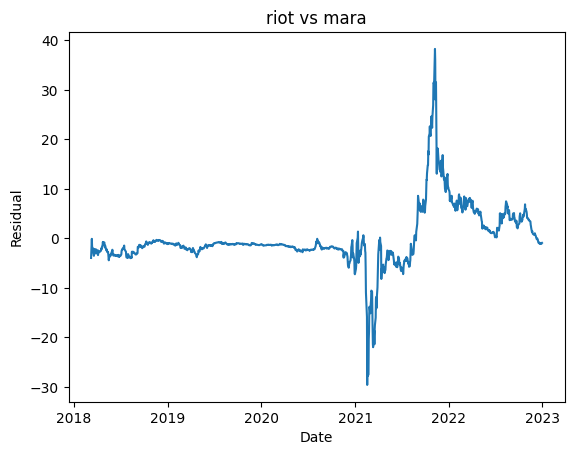

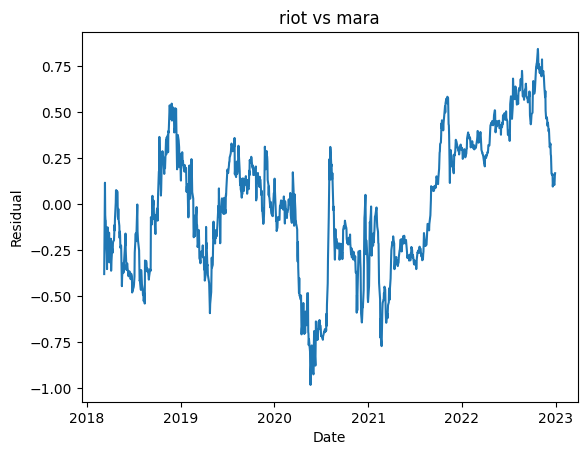

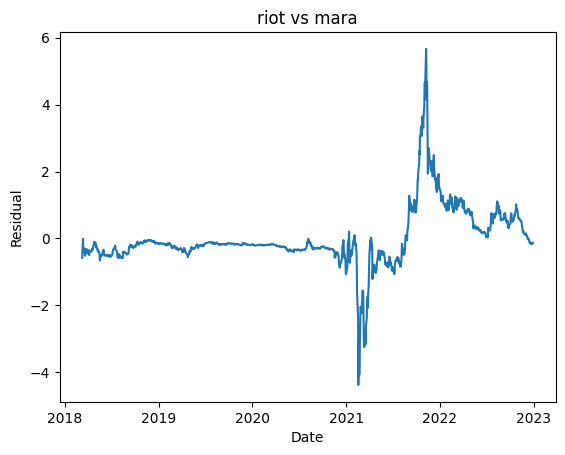

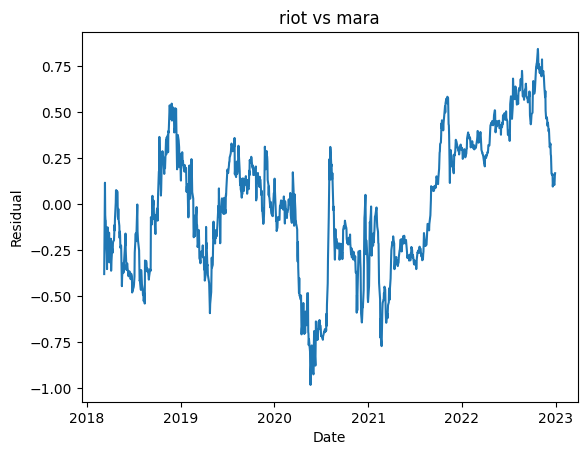

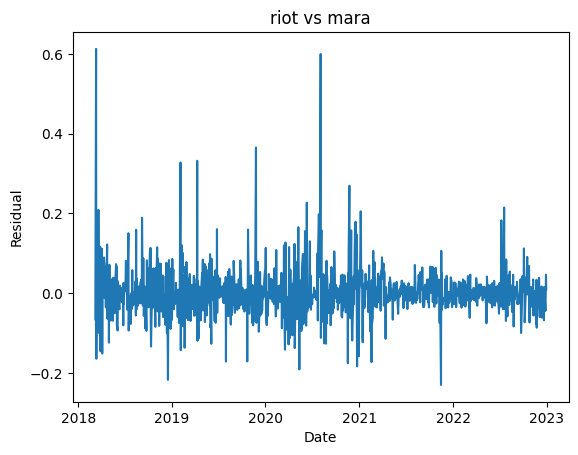

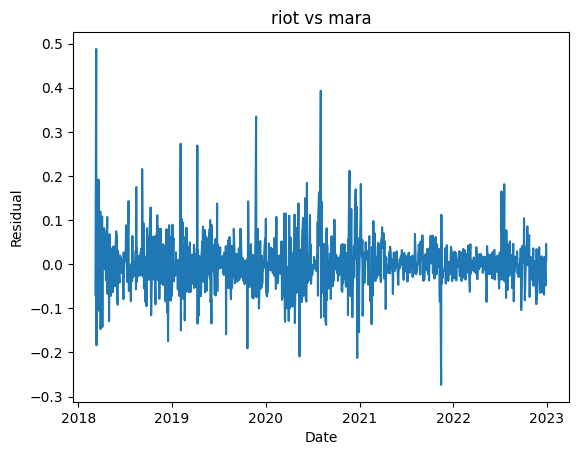

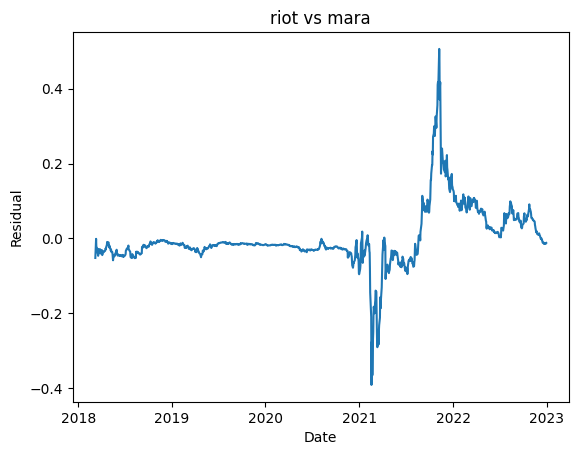

In [19]:
# Perform ADF testing for all training datasets
for key in tr_datasets.keys():
    dataset = tr_datasets[key]
    print(f'Using {key}')
    adf_test(dataset, stock1, stock2, verbose = True, plot = True)

## Backtesting

#### Plain PT

In [290]:
# Generate plain signal time series:
# Delta for portfolio entry and omega is portfolio exit
# Omega being an acceptable range around 0
# 1 = liquidate
# 2 = short stock2 long stock1
# 3 = long stock2 short stock1
# 0 = hold / do nothing
def gen_plain_sigs(train_data, test_data, stock1, stock2):
    # Get the adf residuals using training data
    # in order to generate the delta and omegas
    _, train_resid, _ = adf_test(train_data, stock1, stock2)
    delta = 0.6 * train_resid.std()
    omega = 0.25 * train_resid.std()

    # Get the adf residuals using test data for backtesting
    _, test_resid, _ = adf_test(test_data, stock1, stock2)

    # Current active code of portfolio
    trade_code = 0

    # Generate the signals by comparing residuals to delta
    signals = pd.Series(index = test_resid.index, name = 'signals')
    for date, res in test_resid.items():
        if trade_code == 0:
            if res >= delta:
                signals[date] = 2
                trade_code = 2
            elif res <= -delta:
                signals[date] = 3
                trade_code = 3
            else:
                signals[date] = 0
        else:
            if (trade_code == 2 and res <= omega) or (trade_code == 3 and res >= -omega):
                signals[date] = 1
                trade_code = 0
            else:
                signals[date] = 0

    return signals

In [291]:
# Plain pairs trading algorithm
def plain_pt(ret, signals, stock1, stock2, principal = 1000):
    curr_val = principal
    real_val = pd.Series(index = signals.index, dtype = 'float')
    port_val = pd.DataFrame(columns = [stock1, stock2], index = signals.index)

    # Current active code of portfolio
    trade_code = 0

    # Backtesting portion of code
    # Uses the same logic in the signals to trade
    for i in range(len(signals)):
        if trade_code == 0:
            real_val.iloc[i] = curr_val
            if signals.iloc[i] == 2:
                port_val.iloc[i][stock2] = curr_val * 0.5
                port_val.iloc[i][stock1] = curr_val * 0.5
                trade_code = 2
            elif signals.iloc[i] == 3:
                port_val.iloc[i][stock2] = curr_val * 0.5
                port_val.iloc[i][stock1] = curr_val * 0.5
                trade_code = 3
            else:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
        else:
            if trade_code == 2:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 - ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 + ret.iloc[i][stock1])
            elif trade_code == 3:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 + ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 - ret.iloc[i][stock1])

            curr_val = port_val.iloc[i][stock2] + port_val.iloc[i][stock1]
            real_val.iloc[i] = curr_val

            if signals.iloc[i] == 1:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
                trade_code = 0

    real_ret = real_val.pct_change().dropna()
    return real_val, real_ret

#### LSTM PT

In [292]:
# Get true labels
def get_true_labels(data, stock1, stock2, period):
    # Get stock data
    s1 = data[stock1]
    s2 = data[stock2]
   
    labels = pd.Series(index = data.index[:-period], name = 'labels')
    for i in range(len(data) - 10):
        date = data.index[i]

        # Get current conditions
        s1_entry = s1.iloc[i]
        s2_entry = s2.iloc[i]

        # Assume shorting greater value
        if s1_entry > s2_entry:
            s1_greater = True
        else:
            s1_greater = False

        # Get later conditions
        if s1_greater == True:
            s1_gain = np.max([s1_entry - s1.iloc[1 + period], 0])
            s2_gain = np.max([s2.iloc[1 + period] - s2_entry, 0])
            
        else:
            s1_gain = np.max([s1.iloc[i + period] - s1_entry, 0])
            s2_gain = np.max([s2_entry - s2.iloc[1 + period], 0])

        if s1_gain + s2_gain == 0:
            s1_prop = 0.5
        else:
            s1_prop = s1_gain / (s1_gain + s2_gain)

        if s1_prop > 0.75:
            labels[date] = 2
        elif s1_prop > 0.25 and s1_prop <= 0.75:
            labels[date] = 1
        else:
            labels[date] = 0
                
    return labels

In [293]:
# Reshape data for LSTM
def reshape_data(X_data, y_data, time_steps):
    y_ind = np.arange(time_steps, len(y_data), time_steps)
    y_out = y_data.iloc[y_ind]

    num_rows_X = len(y_out)
    X_out = X_data.iloc[range(time_steps * num_rows_X)]
    X_out = np.reshape(X_out, (num_rows_X, time_steps, 2))

    return X_out, y_out

In [294]:
def oversample(data_x, data_y, max_size):
    df = pd.DataFrame(data_y).reset_index().drop('date', axis = 'columns')
    for label in range(3):
        filter_indices = df[df['labels'] == label].index
        filtered_array = np.take(data_x, filter_indices, axis = 0)
        sample_indices = np.random.choice(len(filtered_array), max_size - len(filter_indices))
        sample_x = filtered_array[sample_indices]
        data_x = np.concatenate((data_x, sample_x), axis = 0)
        data_y = np.concatenate((data_y, np.full(len(sample_x), label)), axis = 0)
        
    return data_x, data_y

In [295]:
def train_NN(tr_data, logret, stock1, stock2, period, time_steps):
    # Generate true labels for training data
    labels = get_true_labels(tr_data, stock1, stock2, period)
    features = pd.concat([logret[stock1], logret[stock2]], axis = 'columns')[:-period]

    # Set up data for training
    reshaped_train_X, reshaped_train_y = reshape_data(features, labels, time_steps)
    max_size = np.max(np.unique(reshaped_train_y, return_counts = True)[1])
    lstm_train_X, lstm_train_y = oversample(reshaped_train_X, reshaped_train_y, max_size)

    # Build LSTM
    lstm = keras.Sequential()
    lstm.add(keras.layers.Input(shape=(time_steps, 2)))
    lstm.add(keras.layers.LSTM(16, return_sequences = True, activation = 'relu')) 
    lstm.add(keras.layers.LSTM(32, activation = 'relu'))
    lstm.add(keras.layers.Dense(3, activation = 'softmax')) 
    lstm.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

    # Train LSTM
    history = lstm.fit(lstm_train_X, lstm_train_y, epochs = 1000, validation_split = 0.1, verbose = 0)
    
    # View improvement over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training','Validation'])
    plt.title('Loss Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    return lstm

In [296]:
def get_weights(lstm, data):
    probs = lstm.predict(data)
    label = probs.argmax(axis = -1)
    if label == 0:
        weight = 0.25
    elif label == 1:
        weight = 0.5
    else:
        weight = 0.75
    return weight

In [297]:
# NN pairs trading algorithm
def lstm_pt(tr_data, te_data, ret, signals, tr_logret, te_logret, stock1, stock2, period, time_steps, principal = 1000):
    curr_val = principal
    real_val = pd.Series(index = signals.index, dtype = 'float')
    port_val = pd.DataFrame(columns = [stock1, stock2], index = signals.index)
    
    # Train neural network
    lstm = train_NN(tr_data, tr_logret, stock1, stock2, period, time_steps)

    # Generate true labels for testing data
    labels = get_true_labels(te_data, stock1, stock2, period)
    features = pd.concat([te_logret[stock1], te_logret[stock2]], axis = 'columns')[:-period]

    # Get the accuracy score and confusion matrix
    lstm_test_X, lstm_test_y = reshape_data(features, labels, time_steps)
    probs = lstm.predict(lstm_test_X)
    pred_y = probs.argmax(axis = -1)
    print(f'\nAccuracy Score: {accuracy_score(lstm_test_y, pred_y)}')
    print(f'Confusion Matrix:\n {confusion_matrix(lstm_test_y, pred_y)}')

    # Current active code of portfolio
    trade_code = 0

    # Backtesting portion of code
    # Uses the same logic in the signals to trade
    for i in range(len(signals) - period):
        if trade_code == 0:
            real_val.iloc[i] = curr_val
            # If no signal then we just continue
            if signals.iloc[i] == 0:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
                continue

            # If signal we need to allocate portfolio
            # Reshape data for LSTM
            lstm_test_X, _ = reshape_data(features[i - time_steps: i + 1], labels[i - time_steps: i + 1], time_steps)
            weight = get_weights(lstm, lstm_test_X)
            port_val.iloc[i][stock2] = curr_val * weight 
            port_val.iloc[i][stock1] = curr_val * (1 - weight)
            if signals.iloc[i] == 2:
                trade_code = 2
            elif signals.iloc[i] == 3:
                trade_code = 3
                
        else:
            if trade_code == 2:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 - ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 + ret.iloc[i][stock1])
            elif trade_code == 3:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 + ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 - ret.iloc[i][stock1])

            curr_val = port_val.iloc[i][stock2] + port_val.iloc[i][stock1]
            real_val.iloc[i] = curr_val

            if signals.iloc[i] == 1:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
                trade_code = 0

    real_ret = real_val.pct_change().dropna()
    return real_val, real_ret

##### LSTM Pairs Trading Backtest

([<matplotlib.axis.XTick at 0x2106fa35fc0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

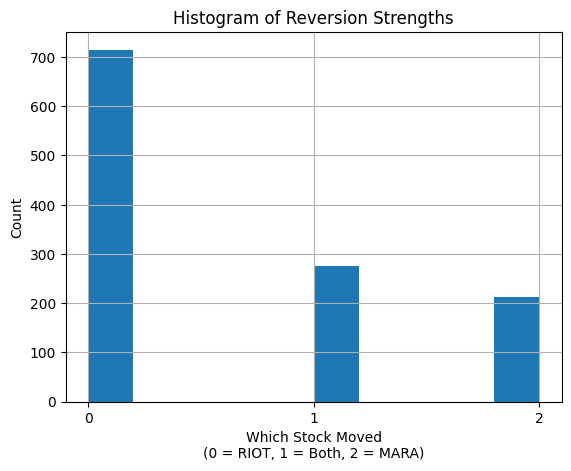

In [298]:
labels = get_true_labels(tr_datasets[option], stock1, stock2, 10)
labels.hist()
plt.title('Histogram of Reversion Strengths')
plt.xlabel('Which Stock Moved\n(0 = RIOT, 1 = Both, 2 = MARA)')
plt.ylabel('Count')
plt.xticks([0, 1, 2])

In [299]:
# Compute signals for models
te_signals = pd.DataFrame()
te_signals[option] = gen_plain_sigs(tr_datasets[option], te_datasets[option], stock1, stock2)
te_signals.dropna(inplace = True)

2/2 [==============================] - 0s 2ms/step

Accuracy Score: 0.4418604651162791
Confusion Matrix:
 [[ 5  0  2]
 [ 3  3  0]
 [11  8 11]]
1/1 [==============================] - 0s 13ms/step


C:\Users\markl\AppData\Local\Temp\ipykernel_34468\798731094.py:62: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  real_ret = real_val.pct_change().dropna()


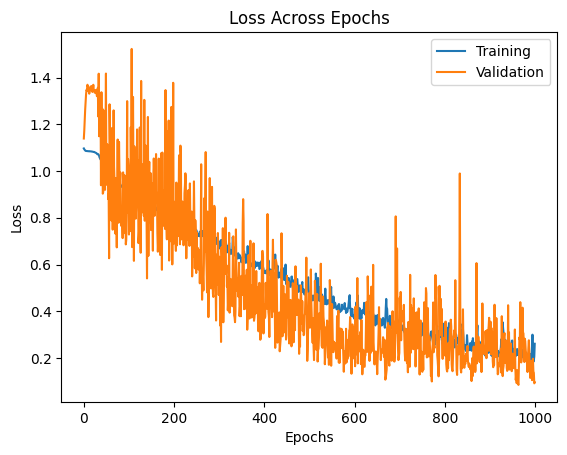

In [300]:
# Perform backtesting
val, ret = lstm_pt(tr_datasets[option], te_datasets[option], te_datasets['ret'], te_signals[option], 
                   tr_datasets['logret'], te_datasets['logret'], stock1, stock2, 10, 5)
te_backtest_ret = pd.DataFrame(ret, columns = [option])
te_backtest_val = pd.DataFrame(val, columns = [option])
te_backtest_cum_ret = (te_backtest_ret + 1).cumprod()

##### Plain Pairs Trading Backtest

In [301]:
# Perform backtesting
val, ret = plain_pt(te_datasets['ret'], te_signals[option], stock1, stock2)
pt_backtest_ret = pd.DataFrame(ret, columns = [option + ' (Plain)'])
pt_backtest_val = pd.DataFrame(val, columns = [option + ' (Plain)'])
pt_backtest_cum_ret = (pt_backtest_ret + 1).cumprod()

In [302]:
# Get benchmark performance
te_bench_ret = te_bench_close.pct_change().dropna()
te_bench_cum_ret = (te_bench_ret + 1).cumprod()

Text(0.5, 1.0, 'Validiation Portfolio Value with Principal = $1000')

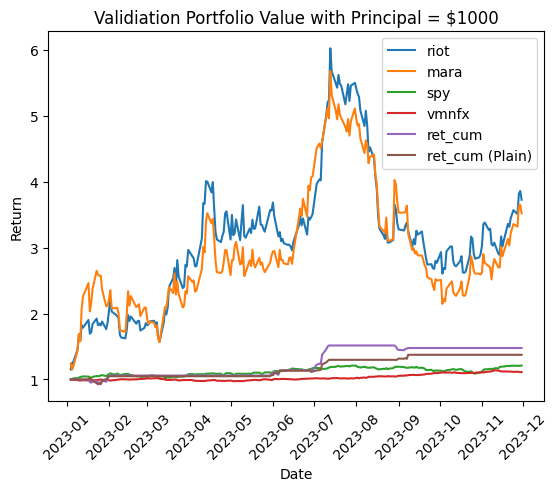

In [303]:
# Combine all test data
te_comb_cum_ret = pd.concat([te_bench_cum_ret, te_backtest_cum_ret, pt_backtest_cum_ret], axis = 'columns')
te_comb_cum_ret.plot()

# Plot details
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Return')
plt.title(f'Validiation Portfolio Value with Principal = $1000')

Text(0.5, 1.0, 'Portfolio Returns vs SPY and VMNFX (Delta = 0.6) (Omega = 0.25)')

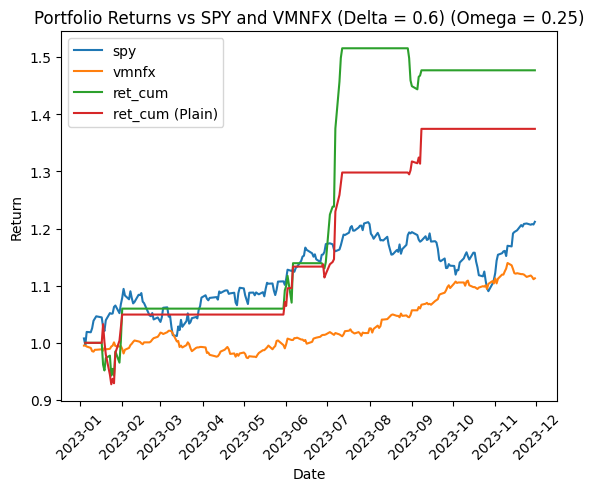

In [304]:
# Remove RIOT and MARA
te_comb_cum_ret_small = te_comb_cum_ret.drop(columns = [stock1, stock2])
te_comb_cum_ret_small.plot()

# Plot details
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Return')
plt.title(f'Portfolio Returns vs SPY and VMNFX (Delta = 0.6) (Omega = 0.25)')

## Strategy Performance Analysis

In [305]:
# Calculate the daily volatiltiy of data over <period> days
def volatility(data, period):
    # If period = -1 use entire data
    if period == -1:
        return data.std()

    # Else calculate series of volatility
    vol = pd.Series(dtype = 'object', name = 'vol')
    for t, data_ind in enumerate(np.arange(period, len(data))):
        vol.loc[t] = data[data_ind - period: data_ind].std()

    return vol

In [306]:
# Computes the value at risk across data for every <period> days
def value_at_risk(value, ret, peariod, alpha):
    var = pd.Series(dtype = 'object', name = 'value_at_risk')
    for t, data_ind in enumerate(np.arange(period, len(ret))):
        segment = ret[data_ind - period: data_ind]
        var.loc[t] = np.percentile(segment, 100 * (1 - alpha)) * value[t]

In [307]:
# Get max drawdown calculated for days = period
def max_dd(data, period):
    drawdown = pd.Series(dtype = 'object', name = 'drawdown')
    for t, data_ind in enumerate(np.arange(period, len(data))):
        segment = data[data_ind - period: data_ind]
        peak_val = segment.max()
        peak_val_ind = segment.argmax()
        segment = segment[peak_val_ind:]
        low_val = segment.min()
        drawdown.loc[t] = (low_val - peak_val) / peak_val
    return drawdown.min()

In [308]:
def strat_summary(val, ret):
    # Daily and annualized return metrics
    amean = ret.mean()
    amean_ann = amean * np.sqrt(252)
    gmean = (ret + 1).product() ** (1 / len(ret)) - 1
    gmean_ann =  gmean * np.sqrt(252)
    min_ret = ret.min()
    min_ret_ann = min_ret * np.sqrt(252)

    # Maximum 10 days drawdown
    max_dd_10 = max_dd(val, 10)

    # Volatility and Sharpe Ratio overall and annualized
    vol = volatility(ret, -1)
    vol_ann = vol * np.sqrt(252 / len(ret))
    sharpe = amean / vol
    sharpe_ann = amean_ann / vol_ann

    # Skewness, Kurtosis
    skewness = ret.skew()
    kurtosis = ret.kurtosis()

    return pd.Series([amean, amean_ann, gmean, gmean_ann, min_ret, min_ret_ann, max_dd_10, vol,
                    vol_ann, sharpe, sharpe_ann, skewness, kurtosis],
                index = ['daily_amean', 'daily_amean_ann', 'daily_gmean', 'daily_gmean_ann',
                            'daily_min_ret', 'daily_min_ret_ann', 'max_dd_10', 'vol', 'vol_ann',
                            'sharpe', 'sharpe_ann', 'skewness', 'kurtosis'])

In [309]:
# Get returns of all time series
te_comb_ret = pd.concat([pt_backtest_ret, te_backtest_ret, te_bench_ret], axis = 'columns').dropna()
te_comb_val = pd.concat([pt_backtest_val, te_backtest_val, te_bench_close], axis = 'columns').dropna()

In [310]:
# Show summaries of all the strategies
summaries = pd.DataFrame()
for col in te_comb_ret.columns:
    summary = strat_summary(te_comb_val[col], te_comb_ret[col])
    summaries = pd.concat([summaries, summary], axis = 'columns')
summaries.columns = te_comb_val.columns
summaries

,ret_cum (Plain),ret_cum,riot,mara,spy,vmnfx
daily_amean,0.001440,0.001798,0.007136,0.007198,0.000844,0.000499
daily_amean_ann,0.022860,0.028542,0.113274,0.114269,0.013404,0.007919
daily_gmean,0.001396,0.001712,0.005162,0.004583,0.000809,0.000491
daily_gmean_ann,0.022161,0.027175,0.081943,0.072755,0.012843,0.007791
daily_min_ret,-0.036046,-0.042101,-0.133436,-0.174433,-0.020061,-0.013578
daily_min_ret_ann,-0.572217,-0.668338,-2.118224,-2.769030,-0.318457,-0.215548
max_dd_10,-0.101845,-0.057337,-0.372331,-0.297074,-0.058160,-0.028617
vol,0.009506,0.013391,0.063645,0.073848,0.008424,0.004025
vol_ann,0.009994,0.014078,0.066911,0.077638,0.008856,0.004232
sharpe,0.151480,0.134272,0.112114,0.097474,0.100236,0.123929
